<a href="https://colab.research.google.com/github/AbeerProg/RRDS/blob/main/DL_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LAST With Comp Table + Simple + Uni direction**

In [ ]:
# ✅ Install and Import Dependencies
!pip install openpyxl --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional,
                                     Dense, Dropout, Flatten, Concatenate)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# ✅ Load and Describe Dataset
file_path = '/content/your_dataset.xlsx'
df = pd.read_excel(file_path)

print("\n📊 Dataset Overview:")
print(f"Total samples: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(df.iloc[:5])

In [35]:
# ✅ Drop rows with missing text or labels
df = df.dropna(subset=[df.columns[0], df.columns[-1]])
df = df.dropna()  # Optional: drop rows with missing features

# ✅ Clean Labels
df[df.columns[-1]] = df[df.columns[-1]].astype(int)

# ✅ Text Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df[df.columns[0]] = df[df.columns[0]].astype(str).apply(clean_text)

# ✅ Tokenization and Padding
texts = df.iloc[:, 0].tolist()
max_words = 10000
max_len = 150

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X_text = pad_sequences(sequences, maxlen=max_len)

# ✅ Numeric Features (columns 2 to 12)
X_features_raw = df.iloc[:, 1:-1].values
scaler = StandardScaler()
X_features = scaler.fit_transform(X_features_raw)

# ✅ Labels
y = df.iloc[:, -1].values

# ✅ Train-Test Split
X_train_text, X_test_text, X_train_features, X_test_features, y_train, y_test = train_test_split(
    X_text, X_features, y, test_size=0.2, random_state=42
)

# ✅ Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

In [36]:


# ✅ Model Definitions
def build_cnn():
    text_input = Input(shape=(max_len,))
    x = Embedding(max_words, 128)(text_input)
    x = Conv1D(32, 3, activation='relu')(x)  # reduced filters and kernel size
    x = MaxPooling1D(2)(x)
    x = Flatten()(x)

    feat_input = Input(shape=(X_features.shape[1],))
    f = Dense(32, activation='relu')(feat_input)  # reduced dense layer size

    merged = Concatenate()([x, f])
    merged = Dropout(0.3)(merged)  # slightly reduced dropout
    output = Dense(1, activation='sigmoid')(merged)

    model = Model([text_input, feat_input], output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])
    return model

def build_lstm():
    text_input = Input(shape=(max_len,))
    x = Embedding(max_words, 128)(text_input)
    x = LSTM(32)(x)  # switched to unidirectional LSTM

    feat_input = Input(shape=(X_features.shape[1],))
    f = Dense(32, activation='relu')(feat_input)  # reduced dense layer size

    merged = Concatenate()([x, f])
    merged = Dropout(0.3)(merged)  # slightly reduced dropout
    output = Dense(1, activation='sigmoid')(merged)

    model = Model([text_input, feat_input], output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])
    return model

def build_cnn_lstm():
    text_input = Input(shape=(max_len,))
    x = Embedding(max_words, 128)(text_input)
    x = Conv1D(32, 3, activation='relu')(x)  # reduced filters and kernel size
    x = MaxPooling1D(2)(x)
    x = LSTM(32)(x)  # switched to unidirectional LSTM

    feat_input = Input(shape=(X_features.shape[1],))
    f = Dense(32, activation='relu')(feat_input)  # reduced dense layer size

    merged = Concatenate()([x, f])
    merged = Dropout(0.3)(merged)  # slightly reduced dropout
    output = Dense(1, activation='sigmoid')(merged)

    model = Model([text_input, feat_input], output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])
    return model


In [37]:

# ✅ Train and Evaluate
model_histories = {}
def train_and_evaluate(model_fn, name):
    print(f" Training {name}...")
    model = model_fn()
    history = model.fit([X_train_text, X_train_features], y_train,
                        validation_split=0.1, epochs=10, batch_size=64,
                        callbacks=callbacks, verbose=1)

    model_histories[name] = history.history  # Save history for comparison

    y_pred = (model.predict([X_test_text, X_test_features]) > 0.5).astype("int32")

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f" {name} Classification Report:")
    report = classification_report(y_test, y_pred, output_dict=True)
    print(pd.DataFrame(report).T)

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"]).plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.grid(False)
    plt.show()

    return acc, prec, rec, f1


 Training CNN...
Epoch 1/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6218 - loss: 0.6774

284/284 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6220 - loss: 0.6774 - val_accuracy: 0.7378 - val_loss: 0.6406
Epoch 2/10
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7285 - loss: 0.6276

284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7285 - loss: 0.6274 - val_accuracy: 0.7517 - val_loss: 0.5854
Epoch 3/10
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7595 - loss: 0.5691

284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7595 - loss: 0.5689 - val_accuracy: 0.7761 - val_loss: 0.5235
Epoch 4/10
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8052 - loss: 0.4999

284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8052 - loss: 0.4998 - val_accuracy: 0.8297 - val_loss: 0.4647
Epoch 5/10
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8335 - loss: 0.4465

284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8335 - loss: 0.4464 - val_accuracy: 0.8426 - val_loss: 0.4180
Epoch 6/10
283/284 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8526 - loss: 0.4011

284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8527 - loss: 0.4010 - val_accuracy: 0.8580 - val_loss: 0.3823
Epoch 7/10
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8643 - loss: 0.3621

284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8644 - loss: 0.3620 - val_accuracy: 0.8654 - val_loss: 0.3553
Epoch 8/10
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8766 - loss: 0.3330

284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8766 - loss: 0.3329 - val_accuracy: 0.8694 - val_loss: 0.3358
Epoch 9/10
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8885 - loss: 0.3010

284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8885 - loss: 0.3010 - val_accuracy: 0.8734 - val_loss: 0.3215
Epoch 10/10
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8983 - loss: 0.2804

284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8982 - loss: 0.2804 - val_accuracy: 0.8699 - val_loss: 0.3107
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
 CNN Classification Report:
              precision    recall  f1-score      support
0              0.887426  0.845065  0.865727  2472.000000
1              0.857090  0.896565  0.876383  2562.000000
accuracy       0.871275  0.871275  0.871275     0.871275
macro avg      0.872258  0.870815  0.871055  5034.000000
weighted avg   0.871986  0.871275  0.871150  5034.000000


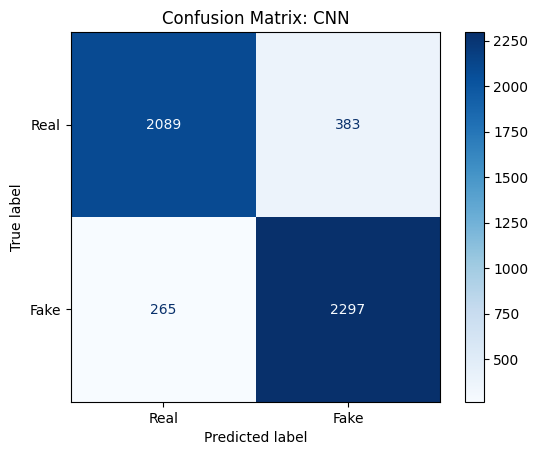

 Training LSTM...
Epoch 1/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.6645 - loss: 0.6259 - val_accuracy: 0.8163 - val_loss: 0.5302
Epoch 2/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.7808 - loss: 0.5239 - val_accuracy: 0.8312 - val_loss: 0.4611
Epoch 3/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.8115 - loss: 0.4591 - val_accuracy: 0.8386 - val_loss: 0.4159
Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.8406 - loss: 0.4100 - val_accuracy: 0.8496 - val_loss: 0.3843
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.8552 - loss: 0.3741 - val_accuracy: 0.8525 - val_loss: 0.3610
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.8728 - loss: 0.3357 - val_accuracy: 0.8530 - val_loss: 0.3440
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.8821 - loss: 0.3041 - val_accuracy: 0.8520 - val_loss: 0.3330
Epoch 8/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.8958

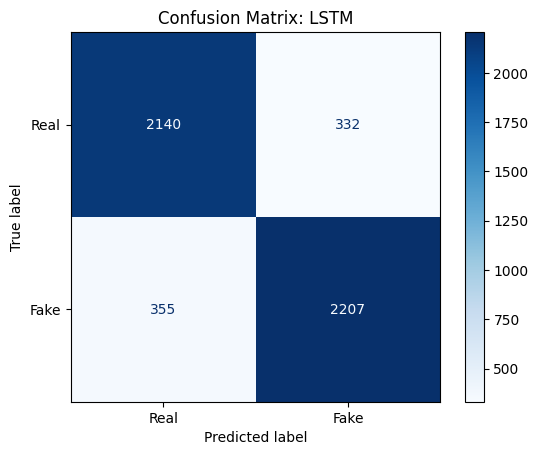

 Training CNN+LSTM...
Epoch 1/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.4356 - loss: 0.7978 - val_accuracy: 0.5924 - val_loss: 0.6821
Epoch 2/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.6096 - loss: 0.6724 - val_accuracy: 0.6922 - val_loss: 0.5986
Epoch 3/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6998 - loss: 0.5914 - val_accuracy: 0.7547 - val_loss: 0.5216
Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.7618 - loss: 0.5123 - val_accuracy: 0.7865 - val_loss: 0.4707
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.7952 - loss: 0.4600 - val_accuracy: 0.8078 - val_loss: 0.4362
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.8293 - loss: 0.4057 - val_accuracy: 0.8208 - val_loss: 0.4092
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.8512 - loss: 0.3640 - val_accuracy: 0.8292 - val_loss: 0.3904
Epoch 8/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.

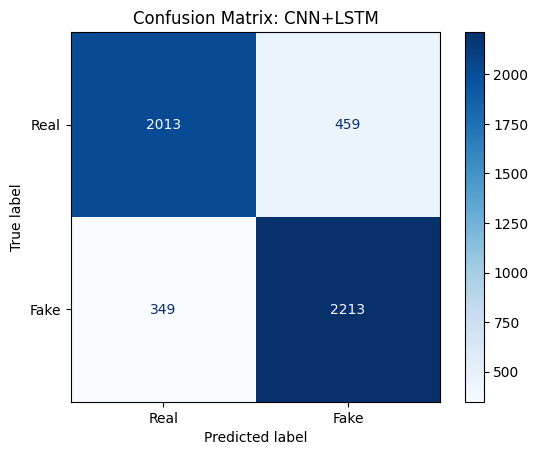

In [38]:

# ✅ Run All Models
results = {}
results["CNN"] = train_and_evaluate(build_cnn, "CNN")
results["LSTM"] = train_and_evaluate(build_lstm, "LSTM")
results["CNN+LSTM"] = train_and_evaluate(build_cnn_lstm, "CNN+LSTM")


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


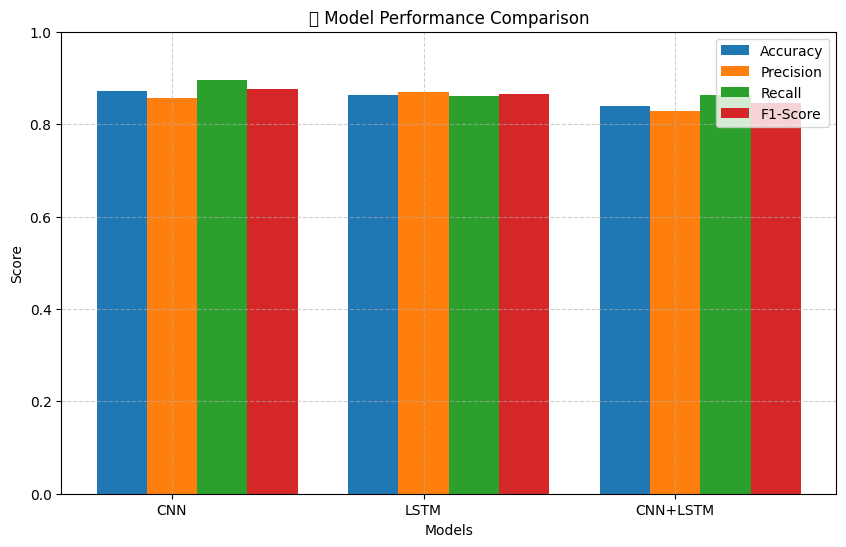

In [39]:

# ✅ Visualize and Compare
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
labels = list(results.keys())
values = np.array(list(results.values())).T

x = np.arange(len(labels))
width = 0.2

plt.figure(figsize=(10, 6))
for i in range(len(metrics)):
    plt.bar(x + i * width, values[i], width, label=metrics[i])

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('📊 Model Performance Comparison')
plt.xticks(x + width, labels)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

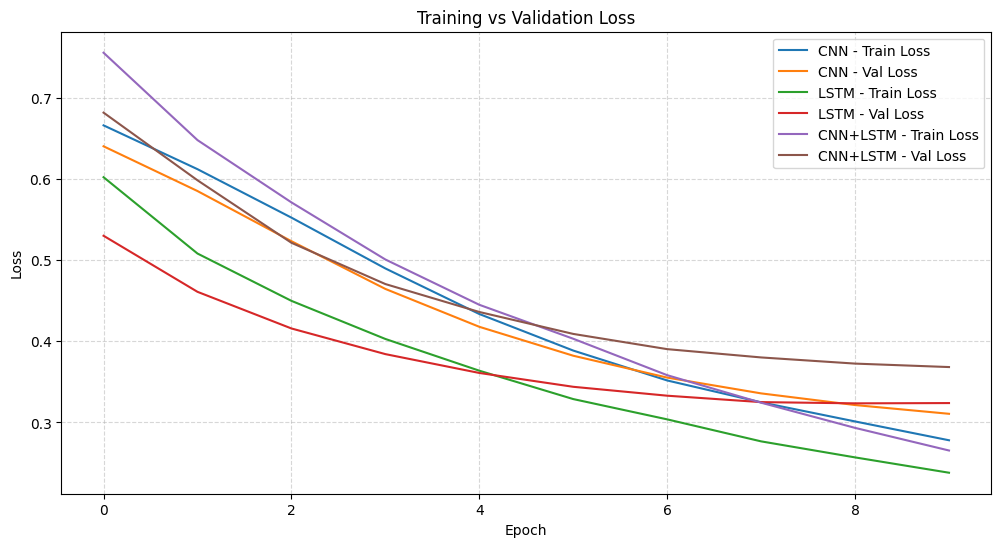

 Model Comparison Table:
          Accuracy  Precision  Recall  F1-Score
CNN         0.8713     0.8571  0.8966    0.8764
LSTM        0.8635     0.8692  0.8614    0.8653
CNN+LSTM    0.8395     0.8282  0.8638    0.8456


In [40]:


# ✅ Compare Loss Curves
plt.figure(figsize=(12, 6))
for name, history in model_histories.items():
    plt.plot(history['loss'], label=f'{name} - Train Loss')
    plt.plot(history['val_loss'], label=f'{name} - Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# ✅ Show Comparison Table
comparison_df = pd.DataFrame(results, index=metrics).T
print(" Model Comparison Table:")
print(comparison_df.round(4))
